# 11. 이미지분할 실습
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow
```

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow


## **과제1 옥스포드 펫 이미지 분할**
---

---
### **데이터셋: Oxford Pet dataset**
---
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/oxford-pet.jpeg?raw=true)

#### **1. 데이터셋 다운로드**

* instance-level-human-parsing.zip(2.7G): https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz


```
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

```

In [53]:
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  74.4M      0  0:00:10  0:00:10 --:--:-- 49.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  14.3M      0  0:00:01  0:00:01 --:--:-- 14.3M


In [54]:
train_img_paths = sorted(glob.glob('/content/images/*jpg'))
train_mask_paths = sorted(glob.glob('/content/annotations/trimaps/*'))

print('* Training',len(train_img_paths),len(train_mask_paths))


* Training 7390 7390


In [55]:
from tensorflow.keras import utils
from PIL import ImageOps

In [56]:
def plot_img_mask(img,mask,cmap='gray'):
  plt.figure(figsize=(20,10))
  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img)

  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(img)
  plt.imshow(mask,alpha=0.6,cmap =cmap)

  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(mask,cmap = cmap)
  plt.show()


(500, 465)
(500, 465)


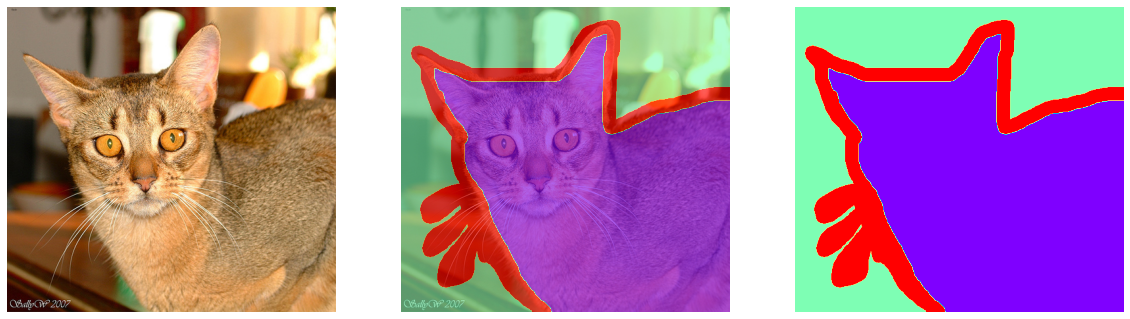

In [57]:
idx= 4
img = utils.load_img(train_img_paths[idx])
print(img.size)

mask = utils.load_img(train_mask_paths[idx],color_mode='grayscale')
mask = ImageOps.autocontrast(mask)
print(mask.size) 
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(img)
plt.imshow(mask,alpha=0.6,cmap ='rainbow')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(mask,cmap = 'rainbow')
plt.show()

In [58]:

IMG_SIZE =160
BATCH_SIZE= 16
N_CLASS = 3

In [59]:
img_path = train_img_paths[0]
mask_path = train_mask_paths[0]
def read_from_path(img_path,mask_path):


#이미지
  img = tf.io.read_file(img_path)
  img =tf.image.decode_jpeg(img,channels=3)
  img = tf.image.resize(img,size=[IMG_SIZE,IMG_SIZE])
  img=img/127.5-1

#마스크
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask,channels=1)
  mask = tf.image.resize(mask,size=[IMG_SIZE,IMG_SIZE])
  mask = tf.cast(mask,tf.int8)   #타입 정하지않으면 자동으로 플롯 타입이되어버린다
  return img,mask


In [60]:
def generate_ds(img_paths,mask_paths):
  ds = tf.data.Dataset.from_tensor_slices((img_paths,mask_paths))
  ds = ds.map(read_from_path, num_parallel_calls=tf.data.AUTOTUNE)#데이터셋 셋팅 빨라지게 하는거
  ds = ds.batch(BATCH_SIZE,drop_remainder=True)
  return ds

In [61]:
train_ds = generate_ds(train_img_paths,train_mask_paths)
train_ds

<BatchDataset shapes: ((16, 160, 160, 3), (16, 160, 160, 1)), types: (tf.float32, tf.int8)>

---
### **모델: UNet**
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)


https://github.com/zhixuhao/unet/blob/master/model.py

In [62]:
from tensorflow.keras import layers, models, Input, utils

def build_model(img_size, num_classes):
  inputs = Input(shape=( img_size, img_size, 3) )

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x_pre = x
#크기를 줄이는부분
  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(x_pre)
    x = layers.add([x, residual])
    x_pre = x
#크기를 다시 키우는 부분
  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(x_pre)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    x_pre = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = models.Model(inputs, outputs)
  return model

In [63]:
model= build_model(IMG_SIZE,N_CLASS)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 80, 80, 32)   896         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 80, 80, 32)  128         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [67]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [68]:
optimizer = tf.keras.optimizers.Adam()

In [69]:
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy'])

In [ ]:
from tensorflow.keras import callbacks
ckp =callbacks.ModelCheckpoint('model.h5',save_best_only=True)
history=model.fit(train_ds,
                  epochs=10,
                  callbacks=[ckp])

Epoch 1/10
461/461 [==============================] - 96s 201ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/10
434/461 [===========================>..] - ETA: 5s - loss: nan - accuracy: 0.0000e+00

In [ ]:
history= model.fit()

---
### **추론**
---

## **과제2 텐서플로우 튜토리얼**
---

https://www.tensorflow.org/tutorials/images/segmentation?hl=ko